In [1]:
import random
import numpy as np
from game import Game, Move, Player
from copy import deepcopy
from tqdm import tqdm

border = []
for i in range(5):
    for j in range(5):
        if i == 0 or i == 4 or j == 0 or j == 4:
            border.append((i, j))
BORDER = (list(set(border)))
print(len(BORDER))

ALL_MOVES = []
for pos in BORDER:
    possible_moves = [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]
            
    if pos[0] == 0: possible_moves.remove(Move.LEFT)
    if pos[0] == 4: possible_moves.remove(Move.RIGHT)
    if pos[1] == 0: possible_moves.remove(Move.TOP)
    if pos[1] == 4: possible_moves.remove(Move.BOTTOM)

    for move in possible_moves: ALL_MOVES.append((pos, move))
N_ALL = len(ALL_MOVES)

class RandomPlayer(Player):
    def __init__(self) -> None:
        super().__init__()

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:

        from_pos = random.choice(BORDER)
        while game.get_board()[from_pos[1], from_pos[0]] == 1 - game.current_player_idx: from_pos = random.choice(BORDER)

        possible_moves = [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]
            
        if from_pos[0] == 0: possible_moves.remove(Move.LEFT)
        if from_pos[0] == 4: possible_moves.remove(Move.RIGHT)
        if from_pos[1] == 0: possible_moves.remove(Move.TOP)
        if from_pos[1] == 4: possible_moves.remove(Move.BOTTOM)
        
        move = random.choice(possible_moves)

        return from_pos, move

16


In [2]:
class ID_generator:
    def __init__(self):
        self.id = -1
    def get_id(self):
        self.id += 1
        return self.id

In [3]:
def rot(n_rot):
    def rot_n(board): 
        return np.rot90(board, k= n_rot)
    return rot_n

def flip_rot(n_rot):
    def flip_rot_n(board): 
        return np.rot90(np.fliplr(board), k= n_rot)
    return flip_rot_n

rot2 = rot(2)
rot3 = rot(3)
flip_rot1 = flip_rot(1)
flip_rot2 = flip_rot(2)
flip_rot3 = flip_rot(3)

In [4]:
# weight definition
INPUT_SHAPE = (24, 5, 5)
WEIGHT_SHAPE = np.array([
    [
        ('dense', 256),
        ('dense', 256),
        ('dense', N_ALL),
    ],
    [
        ('dense', 256),
        ('dense', 256),
        ('dense', N_ALL),
    ],
], dtype= object)

def multiply(x):
    res = 1
    for xx in x: res *= xx
    return res

class MyPlayer(Player):
    def __init__(self, id, heritage= None) -> None:
        super().__init__()

        self.id = id

        if heritage is None:
            self.W = []
            self.b = []

            for branch in WEIGHT_SHAPE:
                branch_w = []
                branch_b = []
                in_shape = INPUT_SHAPE

                for layer in branch:
                    #print(in_shape)
                    #print(layer)

                    if layer[0] == 'dense':
                        in_shape = multiply(in_shape)
                        branch_w.append(np.random.random(size= (in_shape, layer[1])))
                        branch_b.append(np.random.random(size= (layer[1],)))
                        in_shape = (layer[1],)

                    elif layer[0] == 'conv':

                        if len(in_shape) == 2:
                            branch_w.append(np.random.random(size= layer[1]))
                            branch_b.append(np.random.random(size= (layer[1][0],)))
                            in_shape = (layer[1][0], in_shape[0] - layer[1][1] + 1, in_shape[1] - layer[1][2] + 1)

                        else:
                            branch_w.append(np.random.random(size= (layer[1][0] * in_shape[0], layer[1][1], layer[1][2])))
                            branch_b.append(np.random.random(size= (layer[1][0] * in_shape[0],)))
                            in_shape = (layer[1][0] * in_shape[0], in_shape[1] - layer[1][1] + 1, in_shape[2] - layer[1][2] + 1)

                    else: print('error')

                    #print(branch_w[-1].shape)
                    #print(branch_b[-1].shape)
                    #print('-')

                    #print(in_shape)
                #print('-----')

                self.W.append(branch_w)
                self.b.append(branch_b)

            self.W = np.array(self.W, dtype= object)
            self.b = np.array(self.b, dtype= object)

        else:
            self.W = heritage[0]
            self.b = heritage[1]

        self.fitness = 0
        self.until_surrend = 100
        self.epoch_before_death = 3

    def get_id(self): return self.id
    def reset_fitness(self) -> None: self.fitness = 0
    def mod_fitness(self, mod) -> None: self.fitness += mod
    def get_fitness(self): return self.fitness
    def set_fitness(self, new_value) -> None: self.fitness = new_value
    def get_weights(self): return self.W
    def get_biases(self): return self.b
    def prepare_to_surrend(self, amount= 100)-> None: self.until_surrend = amount
    def get_death(self, bonus= None):
        if bonus is not None: self.epoch_before_death = bonus + 1
        self.epoch_before_death -= 1
        return self.epoch_before_death
    
    def add_weights(self, branch_shape):
        new_W = [branch_w for branch_w in self.W]
        new_b = [branch_b for branch_b in self.b]
        branch_w = []
        branch_b = []

        in_shape = INPUT_SHAPE

        for layer in branch_shape:

            if layer[0] == 'dense':
                in_shape = multiply(in_shape)
                branch_w.append(np.random.random(size= (in_shape, layer[1])))
                branch_b.append(np.random.random(size= (layer[1],)))
                in_shape = (layer[1],)

            elif layer[0] == 'conv':

                if len(in_shape) == 2:
                    branch_w.append(np.random.random(size= layer[1]))
                    branch_b.append(np.random.random(size= (layer[1][0],)))
                    in_shape = (layer[1][0], in_shape[0] - layer[1][1] + 1, in_shape[1] - layer[1][2] + 1)

                else:
                    branch_w.append(np.random.random(size= (layer[1][0] * in_shape[0], layer[1][1], layer[1][2])))
                    branch_b.append(np.random.random(size= (layer[1][0] * in_shape[0],)))
                    in_shape = (layer[1][0] * in_shape[0], in_shape[1] - layer[1][1] + 1, in_shape[2] - layer[1][2] + 1)

            else: print('error')

        new_W.append(branch_w)
        new_b.append(branch_b)

        self.W = np.array(self.W, dtype= object)
        self.b = np.array(self.b, dtype= object)
    
    def compute_move(self, X):
        branch_outputs = []

        for i_branch in range(len(self.W)):
            layer_input = deepcopy(X)

            for i_layer in range(len(self.W[i_branch])):
                layer_info = WEIGHT_SHAPE[i_branch][i_layer]

                if layer_info[0] == 'dense':
                    layer_output = np.dot(layer_input.flatten(), self.W[i_branch][i_layer]) + self.b[i_branch][i_layer]
                
                elif layer_info[0] == 'conv':

                    if len(layer_input.shape) == 2:
                        layer_output = np.zeros((layer_info[1][0], layer_input.shape[0] - layer_info[1][1] + 1, layer_input.shape[1] - layer_info[1][2] + 1))
                        for k in range(layer_output.shape[0]):
                            for i in range(layer_output.shape[1]):
                                for j in range(layer_output.shape[2]):
                                    layer_output[k, i, j] = sum(sum(layer_input[i:i+layer_info[1][1], j:j+layer_info[1][2]] * self.W[i_branch][i_layer][k]))
                    
                    else:
                        layer_output = np.zeros((layer_info[1][0] * layer_input.shape[0], layer_input.shape[1] - layer_info[1][1] + 1, layer_input.shape[2] - layer_info[1][2] + 1))
                        for k_in in range(layer_input.shape[0]):
                            for k in range(layer_info[1][0]):
                                for i in range(layer_output.shape[1]):
                                    for j in range(layer_output.shape[2]):
                                        layer_output[k_in*layer_info[1][0]+k, i, j] = sum(sum(layer_input[k_in, i:i+layer_info[1][1], j:j+layer_info[1][2]] * self.W[i_branch][i_layer][k_in*layer_info[1][0]+k]))
                
                else: print('error')

                layer_input = layer_output
                #print(f'{(i_branch, i_layer)} -> {layer_output.shape}')
            
            branch_outputs.append(layer_output)

        output = np.sum(branch_outputs, axis= 0)
        output = np.argmax(output)
        
        return output


    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:

        self.until_surrend -= 1
        if self.until_surrend == 0:
            #print('surrendering')
            self.fitness -= 100
            return (-1, -1), None
        
        ## provare a generare tre mappe dalla board, una per ogni [-1, 0, 1] con 1 se [-1, 0, 1] in tile e 0 se altre
        #--------------------------------------

        board = game.get_board()
        X = np.zeros((3, board.shape[0], board.shape[1]))
        X[0][board == -1] = 1
        X[1][board == 0] = 1
        X[2][board == 1] = 1

        ######################################
        
        ## provare a generare una mappa per simmetria
        #--------------------------------------

        X2 = np.zeros((24, board.shape[0], board.shape[1]))
        c = 0
        for x in X:
            X2[c] = x
            c += 1
            for sim in [np.rot90, rot2, rot3, np.fliplr, flip_rot1, flip_rot2, flip_rot3]:
                X2[c] = sim(x)
                c += 1
        X = X2

        ######################################
        
        # invert the board based on player_turn to better recognize enemies from allies
        #--------------------------------------
        
        if game.current_player_idx == 1: pass
        else:
            tmp = deepcopy(X[1])
            X[1] = deepcopy(X[2])
            X[2] = tmp

        #######################################

        # compute move
        #--------------------------------------

        from_pos, move = ALL_MOVES[self.compute_move(X)]

        #######################################

        # random move if illegal move chosen with penalty
        #--------------------------------------

        if game.get_board()[from_pos[1], from_pos[0]] == 1 - game.current_player_idx:

            #print('random used - penalty')
            self.fitness -= 10

            from_pos = random.choice(BORDER)
            while game.get_board()[from_pos[1], from_pos[0]] == 1 - game.current_player_idx: from_pos = random.choice(BORDER)

            possible_moves = [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]
                
            if from_pos[0] == 0: possible_moves.remove(Move.LEFT)
            if from_pos[0] == 4: possible_moves.remove(Move.RIGHT)
            if from_pos[1] == 0: possible_moves.remove(Move.TOP)
            if from_pos[1] == 4: possible_moves.remove(Move.BOTTOM)
            
            move = random.choice(possible_moves)

        #######################################
            
        # removing 1 to fitness for each move to force active play
        #--------------------------------------
        
        self.fitness -= 1

        #######################################
        
        return from_pos, move

In [5]:
id_gen = ID_generator()
player = MyPlayer(id_gen.get_id())
game = Game()
player.make_move(game)

((0, 3), <Move.BOTTOM: 1>)

In [6]:
N_TRIALS = 50

## maybe N_TRIALS should depend on N_ALL

def evaluate_population(population, fs= None, avg_player = None):

    for p in tqdm(population):
        
        p.reset_fitness()

        for _ in range(N_TRIALS):

            if fs is None or fs == 'onlyfirst':
                p.prepare_to_surrend()
                p.mod_fitness(((1 - Game().play(p, RandomPlayer())) * 2 - 1) * 100)

            if fs is None or fs == 'onlysecond':
                p.prepare_to_surrend()
                p.mod_fitness((Game().play(RandomPlayer(), p) * 2 - 1) * 100)

    if avg_player is not None: evaluate_population_2(population, avg_player, fs= fs)

def evaluate_population_2(population, avg_player, fs= None):

    freeze_fitness = avg_player.get_fitness()

    for p in population:

        for _ in range(1):

            if fs is None or fs == 'first':
                p.prepare_to_surrend()
                avg_player.prepare_to_surrend()
                winner = Game().play(p, avg_player)
                p.mod_fitness(((1 - winner) * 2 - 1) * 100)

            if fs is None or fs == 'second':
                p.prepare_to_surrend()
                avg_player.prepare_to_surrend()
                winner = Game().play(avg_player, p)
                p.mod_fitness((winner * 2 - 1) * 100)
    
    avg_player.set_fitness(freeze_fitness)
            

In [7]:
def procreate_1(p1, p2, c1, c2, id):
    
    W1 = p1.get_weights()
    b1 = p1.get_biases()
    W2 = p2.get_weights()
    b2 = p2.get_biases()

    W3 = deepcopy(W1)
    b3 = deepcopy(b1)

    c = c1 / (c1 + c2)

    for i in range(len(W1)):
        for j in range(len(W1[i])):
            if c < np.random.random():
                W3[i][j] = W2[i][j]
                b3[i][j] = b2[i][j]

    return MyPlayer(id, heritage= (W3, b3))

def procreate_2(p1, p2, c1, c2, id):
    
    W1 = p1.get_weights()
    b1 = p1.get_biases()
    W2 = p2.get_weights()
    b2 = p2.get_biases()

    W3 = deepcopy(W1)
    b3 = deepcopy(b1)

    c = c1 / (c1 + c2)

    for i in range(len(W1)):
        if c < np.random.random():
            W3[i] = W2[i]
            b3[i] = b2[i]

    return MyPlayer(id, heritage= (W3, b3))

def softmax_temp(x, t= 1):
    e_x = np.exp(x / t)
    return e_x / sum(e_x)

def procreation(population, id_generator):
        
    mod_scores = softmax_temp(np.array([p.get_fitness() for p in population]), 1000)
    
    parents = []
    for _ in range(15):
        parents.append(np.random.choice([i for i in range(len(population))], size= (2,), replace= False, p= mod_scores))

    childrens = []
    for pair in parents:
        pi = population[pair[0]]
        pj = population[pair[1]]
        mod_i = mod_scores[pair[0]]
        mod_j = mod_scores[pair[1]]
        
        rand = np.random.random()
        if 0.5 >= rand:
            childrens.append(procreate_1(pi, pj, mod_i, mod_j, id_generator.get_id()))
        else:
            childrens.append(procreate_2(pi, pj, mod_i, mod_j, id_generator.get_id()))

    return childrens

In [8]:
P_MUTATION = 0.2
MUTATION_STRENGTH = 0.01

def mutate_1(p, id):

    Wm = deepcopy(p.get_weights())
    bm = deepcopy(p.get_biases())

    for i in range(len(Wm)):
        for j in range(len(Wm[i])):

            for ii in range(Wm[i][j].shape[0]):
                for jj in range(Wm[i][j].shape[1]):
                    if P_MUTATION >= np.random.random():
                        Wm[i][j][ii, jj] += np.random.normal(0, MUTATION_STRENGTH, size= Wm[i][j][ii, jj].shape)

            for ii in range(bm[i][j].shape[0]):
                if P_MUTATION >= np.random.random():
                    bm[i][j][ii] += np.random.normal(0, MUTATION_STRENGTH, size= bm[i][j][ii].shape)

    return MyPlayer(id, heritage= (Wm, bm))

def mutate_2(p, id):

    Wm = deepcopy(p.get_weights())
    bm = deepcopy(p.get_biases())

    for i in range(len(Wm)):
        for j in range(len(Wm[i])):
            if P_MUTATION >= np.random.random():
                Wm[i][j] += np.random.normal(0, MUTATION_STRENGTH, size= Wm[i][j].shape)
            if P_MUTATION >= np.random.random():
                bm[i][j] += np.random.normal(0, MUTATION_STRENGTH, size= bm[i][j].shape)

    return MyPlayer(id, heritage= (Wm, bm))

def mutation(population, id_generator):

    bases = np.random.choice([i for i in range(len(population))], size= (15,), replace= False)

    mutants = []
    for base in bases:
        p = population[base]
        rand = np.random.random()
        if 0.5 >= rand:
            mutants.append(mutate_1(p, id_generator.get_id()))
        else:
            mutants.append(mutate_2(p, id_generator.get_id()))

    return mutants

In [9]:
MAX_EPOCH = 50
MAX_POPULATION = 100

id_generator = ID_generator()

population = [MyPlayer(id_generator.get_id()) for _ in range(MAX_POPULATION)]

ids = []
ps = []
tot_scores = []
times = []

for epoch in range(MAX_EPOCH):

    print(f'------------------------------------\nepoch {epoch}')

    evaluate_population(population)
    #evaluate_population(population, avg_player= population[len(population) // 2])
    scores = np.array([p.get_fitness() for p in population])

    idx_sort = np.argsort(scores)[::-1]
    scores = scores[idx_sort]
    population = [population[i] for i in idx_sort]

    print(scores[:10])
    print([p.get_id() for p in population[:10]])

    # compute avg ranking
    #--------------------------------------

    for p, s in zip(population, scores):
        p_id = p.get_id()

        if p_id in ids:
            idx = np.argwhere(np.array(ids) == p_id)[0][0]
            tot_scores[idx] += s
            times[idx] += 1

        else:
            ids.append(p_id)
            ps.append(p)
            tot_scores.append(s)
            times.append(1)

    #######################################

    # provare ad implementare morte dopo tot che non si è tra i primi tot
    #--------------------------------------

    to_death = []
    for i, p in enumerate(population):
        bonus_epochs = 4 if i < MAX_POPULATION / 2 else None
        if p.get_death(bonus_epochs) == 0: to_death.append(p)
    for p in to_death: population.remove(p)

    # provare ad implementare morte dopo tot che non si è tra i primi tot
    #--------------------------------------

    #if epoch in [2, 4]:
    #    for p in population: p.add_weights(
    #        [
    #            ('dense', 64),
    #            ('dense', N_ALL),
    #        ]
    #    )

    #######################################

    ## magari aumentare e diminuire aumento popolazione in base a grandezza popolazione

    print(f'before: {len(population)}')

    ## procreazione (probabilita dipendente da fitness)

    childrens = procreation(population, id_generator)
    print(f'n_childrens: {len(childrens)}')

    ## mutazioni (tante ma random su individui random)

    mutants = mutation(population, id_generator)
    print(f'n_mutants: {len(mutants)}')

    for child in childrens: population.append(child)
    for mutant in mutants: population.append(mutant)

    print(f'after: {len(population)}')

    #

------------------------------------
epoch 0


100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


[7050 6720 6684 6645 6505 5978 5831 5726 5226 4996]
[24, 84, 51, 82, 14, 17, 88, 46, 73, 81]
before: 100
n_childrens: 15
n_mutants: 15
after: 130
------------------------------------
epoch 1


100%|██████████| 130/130 [03:34<00:00,  1.65s/it]


[7532 7269 6884 6882 6713 6393 6177 6139 5946 5794]
[24, 109, 102, 101, 113, 73, 14, 88, 114, 105]
before: 130
n_childrens: 15
n_mutants: 15
after: 160
------------------------------------
epoch 2


100%|██████████| 160/160 [04:05<00:00,  1.54s/it]


[7354 6887 6878 6821 6787 6777 6758 6701 6558 6483]
[154, 17, 134, 137, 100, 51, 46, 153, 133, 73]
before: 110
n_childrens: 15
n_mutants: 15
after: 140
------------------------------------
epoch 3


100%|██████████| 140/140 [02:37<00:00,  1.12s/it]


[7738 7352 7241 7010 6983 6867 6829 6811 6737 6637]
[107, 101, 134, 177, 14, 146, 174, 82, 132, 130]
before: 127
n_childrens: 15
n_mutants: 15
after: 157
------------------------------------
epoch 4


100%|██████████| 157/157 [02:36<00:00,  1.00it/s]


[7735 7692 7651 7616 7537 7400 7325 7289 7239 7207]
[198, 218, 191, 24, 215, 140, 166, 197, 204, 101]
before: 131
n_childrens: 15
n_mutants: 15
after: 161
------------------------------------
epoch 5


100%|██████████| 161/161 [02:20<00:00,  1.15it/s]


[8329 8080 7556 7486 7308 7293 7278 7277 7241 7232]
[140, 112, 228, 158, 133, 204, 73, 247, 220, 190]
before: 124
n_childrens: 15
n_mutants: 15
after: 154
------------------------------------
epoch 6


100%|██████████| 154/154 [01:57<00:00,  1.31it/s]


[7643 7535 7442 7385 7341 7301 7281 7224 7071 7053]
[262, 179, 103, 243, 177, 277, 140, 216, 206, 24]
before: 138
n_childrens: 15
n_mutants: 15
after: 168
------------------------------------
epoch 7


100%|██████████| 168/168 [02:01<00:00,  1.38it/s]


[8102 8009 7949 7689 7610 7583 7502 7288 7117 7106]
[255, 238, 112, 114, 174, 135, 193, 302, 200, 179]
before: 148
n_childrens: 15
n_mutants: 15
after: 178
------------------------------------
epoch 8


100%|██████████| 178/178 [02:07<00:00,  1.39it/s]


[7956 7844 7528 7521 7411 7311 7276 7248 7159 7045]
[198, 201, 115, 295, 156, 331, 140, 170, 46, 308]
before: 161
n_childrens: 15
n_mutants: 15
after: 191
------------------------------------
epoch 9


100%|██████████| 191/191 [02:16<00:00,  1.40it/s]


[8200 7775 7731 7692 7662 7524 7523 7485 7426 7385]
[249, 290, 259, 285, 293, 177, 364, 237, 206, 270]
before: 166
n_childrens: 15
n_mutants: 15
after: 196
------------------------------------
epoch 10


100%|██████████| 196/196 [02:23<00:00,  1.36it/s]


[8790 7869 7546 7364 7357 7347 7344 7303 7177 7164]
[342, 295, 162, 238, 315, 235, 190, 81, 319, 395]
before: 172
n_childrens: 15
n_mutants: 15
after: 202
------------------------------------
epoch 11


100%|██████████| 202/202 [02:31<00:00,  1.33it/s]


[8203 7753 7720 7534 7525 7478 7434 7434 7383 7340]
[153, 364, 343, 193, 218, 112, 382, 329, 206, 417]
before: 177
n_childrens: 15
n_mutants: 15
after: 207
------------------------------------
epoch 12


100%|██████████| 207/207 [02:26<00:00,  1.42it/s]


[7793 7663 7647 7548 7531 7471 7419 7419 7405 7395]
[444, 179, 449, 331, 389, 417, 437, 366, 396, 362]
before: 176
n_childrens: 15
n_mutants: 15
after: 206
------------------------------------
epoch 13


100%|██████████| 206/206 [02:21<00:00,  1.45it/s]


[7946 7621 7593 7566 7179 7170 7125 7100 7098 7065]
[290, 112, 264, 450, 319, 358, 415, 438, 460, 312]
before: 165
n_childrens: 15
n_mutants: 15
after: 195
------------------------------------
epoch 14


100%|██████████| 195/195 [02:12<00:00,  1.47it/s]


[7784 7708 7534 7498 7496 7447 7401 7384 7384 7353]
[452, 356, 297, 497, 445, 503, 334, 212, 363, 312]
before: 171
n_childrens: 15
n_mutants: 15
after: 201
------------------------------------
epoch 15


100%|██████████| 201/201 [02:19<00:00,  1.44it/s]


[7932 7694 7573 7476 7406 7401 7322 7309 7283 7281]
[392, 344, 537, 500, 510, 487, 312, 542, 472, 206]
before: 180
n_childrens: 15
n_mutants: 15
after: 210
------------------------------------
epoch 16


100%|██████████| 210/210 [02:25<00:00,  1.45it/s]


[7625 7608 7499 7452 7429 7376 7267 7215 7211 7155]
[506, 558, 162, 557, 465, 369, 566, 417, 503, 137]
before: 179
n_childrens: 15
n_mutants: 15
after: 209
------------------------------------
epoch 17


100%|██████████| 209/209 [02:22<00:00,  1.47it/s]


[8069 7669 7540 7487 7431 7323 7308 7303 7300 7292]
[588, 494, 497, 452, 567, 480, 550, 603, 513, 510]
before: 172
n_childrens: 15
n_mutants: 15
after: 202
------------------------------------
epoch 18


100%|██████████| 202/202 [02:19<00:00,  1.45it/s]


[7759 7717 7493 7427 7421 7418 7406 7364 7253 7248]
[9, 542, 569, 502, 458, 189, 391, 588, 285, 555]
before: 171
n_childrens: 15
n_mutants: 15
after: 201
------------------------------------
epoch 19


100%|██████████| 201/201 [02:20<00:00,  1.43it/s]


[7911 7647 7625 7615 7569 7560 7538 7460 7358 7336]
[569, 190, 315, 597, 581, 655, 630, 212, 598, 628]
before: 179
n_childrens: 15
n_mutants: 15
after: 209
------------------------------------
epoch 20


100%|██████████| 209/209 [02:31<00:00,  1.38it/s]


[7870 7640 7588 7436 7412 7308 7298 7238 7225 7218]
[450, 667, 247, 244, 481, 193, 687, 689, 190, 634]
before: 182
n_childrens: 15
n_mutants: 15
after: 212
------------------------------------
epoch 21


100%|██████████| 212/212 [02:36<00:00,  1.36it/s]


[8254 7945 7915 7601 7560 7545 7503 7347 7290 7174]
[667, 244, 597, 529, 358, 657, 724, 553, 402, 503]
before: 182
n_childrens: 15
n_mutants: 15
after: 212
------------------------------------
epoch 22


100%|██████████| 212/212 [02:34<00:00,  1.37it/s]


[7998 7618 7577 7497 7424 7312 7304 7298 7176 7162]
[618, 657, 529, 556, 741, 695, 594, 450, 617, 748]
before: 177
n_childrens: 15
n_mutants: 15
after: 207
------------------------------------
epoch 23


100%|██████████| 207/207 [02:33<00:00,  1.35it/s]


[7950 7434 7416 7410 7266 7256 7219 7190 7183 7145]
[472, 784, 523, 193, 618, 717, 529, 580, 685, 666]
before: 176
n_childrens: 15
n_mutants: 15
after: 206
------------------------------------
epoch 24


100%|██████████| 206/206 [02:25<00:00,  1.42it/s]


[7813 7703 7498 7419 7336 7307 7299 7259 7234 7216]
[555, 742, 9, 247, 344, 548, 734, 450, 465, 273]
before: 179
n_childrens: 15
n_mutants: 15
after: 209
------------------------------------
epoch 25


100%|██████████| 209/209 [02:22<00:00,  1.47it/s]


[8204 7797 7692 7610 7590 7531 7521 7453 7439 7386]
[757, 391, 556, 735, 783, 444, 339, 807, 842, 472]
before: 176
n_childrens: 15
n_mutants: 15
after: 206
------------------------------------
epoch 26


100%|██████████| 206/206 [02:18<00:00,  1.48it/s]


[8147 7633 7615 7484 7445 7443 7400 7343 7288 7185]
[634, 830, 705, 804, 784, 687, 870, 834, 594, 820]
before: 183
n_childrens: 15
n_mutants: 15
after: 213
------------------------------------
epoch 27


100%|██████████| 213/213 [02:29<00:00,  1.43it/s]


[7826 7803 7761 7757 7757 7709 7435 7429 7368 7362]
[835, 763, 452, 729, 823, 794, 787, 839, 819, 816]
before: 186
n_childrens: 15
n_mutants: 15
after: 216
------------------------------------
epoch 28


100%|██████████| 216/216 [02:32<00:00,  1.42it/s]


[7791 7513 7479 7439 7311 7242 7182 7041 7003 6975]
[885, 898, 705, 687, 472, 858, 402, 784, 844, 777]
before: 183
n_childrens: 15
n_mutants: 15
after: 213
------------------------------------
epoch 29


100%|██████████| 213/213 [02:30<00:00,  1.41it/s]


[7490 7395 7392 7280 7273 7221 7214 7125 7095 7062]
[968, 909, 826, 845, 764, 967, 952, 842, 652, 846]
before: 175
n_childrens: 15
n_mutants: 15
after: 205
------------------------------------
epoch 30


100%|██████████| 205/205 [02:18<00:00,  1.48it/s]


[7733 7657 7627 7616 7564 7530 7528 7456 7417 7413]
[971, 927, 681, 739, 402, 748, 805, 925, 830, 979]
before: 176
n_childrens: 15
n_mutants: 15
after: 206
------------------------------------
epoch 31


100%|██████████| 206/206 [02:18<00:00,  1.48it/s]


[8645 8524 8267 8026 7874 7670 7536 7329 7328 7317]
[503, 946, 901, 362, 772, 1027, 1026, 402, 742, 956]
before: 179
n_childrens: 15
n_mutants: 15
after: 209
------------------------------------
epoch 32


100%|██████████| 209/209 [02:23<00:00,  1.46it/s]


[7845 7829 7770 7596 7572 7570 7537 7446 7437 7329]
[9, 990, 909, 829, 1002, 975, 1052, 444, 555, 1037]
before: 172
n_childrens: 15
n_mutants: 15
after: 202
------------------------------------
epoch 33


100%|██████████| 202/202 [02:21<00:00,  1.42it/s]


[7983 7790 7679 7541 7393 7162 7159 7152 7142 7116]
[958, 1049, 1057, 726, 835, 1044, 1062, 1070, 955, 1008]
before: 169
n_childrens: 15
n_mutants: 15
after: 199
------------------------------------
epoch 34


100%|██████████| 199/199 [02:19<00:00,  1.43it/s]


[7947 7795 7648 7410 7370 7292 7236 7204 7079 7065]
[1041, 1036, 1090, 935, 1044, 977, 1099, 764, 1083, 1105]
before: 178
n_childrens: 15
n_mutants: 15
after: 208
------------------------------------
epoch 35


100%|██████████| 208/208 [02:24<00:00,  1.44it/s]


[8109 7767 7504 7419 7370 7355 7317 7301 7293 7268]
[1041, 1095, 1056, 618, 548, 1047, 1050, 947, 889, 1019]
before: 171
n_childrens: 15
n_mutants: 15
after: 201
------------------------------------
epoch 36


100%|██████████| 201/201 [02:17<00:00,  1.46it/s]


[8100 8067 7751 7630 7450 7389 7386 7361 7342 7263]
[1167, 1055, 987, 1081, 852, 842, 1134, 537, 829, 362]
before: 172
n_childrens: 15
n_mutants: 15
after: 202
------------------------------------
epoch 37


100%|██████████| 202/202 [02:23<00:00,  1.41it/s]


[7670 7600 7544 7532 7372 7351 7277 7233 7217 7189]
[1023, 1033, 1209, 972, 1099, 1176, 1131, 1171, 1045, 1172]
before: 175
n_childrens: 15
n_mutants: 15
after: 205
------------------------------------
epoch 38


100%|██████████| 205/205 [02:25<00:00,  1.41it/s]


[8012 7943 7740 7548 7507 7401 7318 7303 7287 7272]
[1195, 1193, 1150, 1175, 1204, 889, 548, 965, 1049, 1056]
before: 176
n_childrens: 15
n_mutants: 15
after: 206
------------------------------------
epoch 39


100%|██████████| 206/206 [02:30<00:00,  1.37it/s]


[7685 7632 7583 7484 7448 7424 7318 7301 7293 7257]
[885, 1160, 1201, 1172, 444, 1245, 1075, 1105, 1183, 1081]
before: 172
n_childrens: 15
n_mutants: 15
after: 202
------------------------------------
epoch 40


100%|██████████| 202/202 [02:26<00:00,  1.38it/s]


[7853 7686 7646 7576 7532 7456 7320 7303 7285 7214]
[1149, 1287, 1002, 971, 1176, 1254, 1215, 1213, 1109, 1150]
before: 179
n_childrens: 15
n_mutants: 15
after: 209
------------------------------------
epoch 41


100%|██████████| 209/209 [02:30<00:00,  1.39it/s]


[8138 7748 7543 7518 7518 7491 7415 7339 7320 7293]
[1255, 1008, 1211, 1329, 1264, 1268, 1302, 885, 1295, 1209]
before: 178
n_childrens: 15
n_mutants: 15
after: 208
------------------------------------
epoch 42


100%|██████████| 208/208 [02:25<00:00,  1.43it/s]


[7835 7694 7599 7542 7519 7458 7451 7415 7408 7383]
[1338, 971, 1274, 1079, 1310, 1358, 1209, 1340, 1353, 1195]
before: 172
n_childrens: 15
n_mutants: 15
after: 202
------------------------------------
epoch 43


  3%|▎         | 7/202 [00:05<02:40,  1.22it/s]


KeyboardInterrupt: 

1338
[1338, 1358, 1340, 1353, 1359, 1337, 1343, 1332, 1355, 1264]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 4]
[7835.   7458.   7415.   7408.   7219.   7106.   7031.   7023.   6869.
 6789.75]


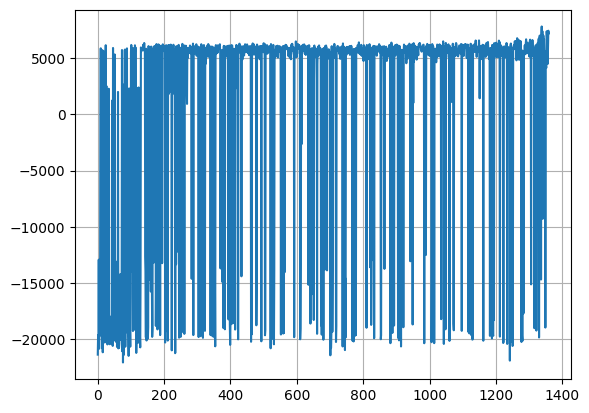

In [10]:
avg_scores = np.array(tot_scores) / np.array(times)

idx_sort = np.argsort(avg_scores)[::-1]

ids = [ids[i] for i in idx_sort]
ps = [ps[i] for i in idx_sort]
tot_scores = [tot_scores[i] for i in idx_sort]
times = [times[i] for i in idx_sort]
avg_scores = avg_scores[idx_sort]

print(population[0].get_id())
print(ids[:10])
print(times[:10])
print(avg_scores[:10])

idx_sort = np.argsort(ids)[::-1]

ids = [ids[i] for i in idx_sort]
ps = [ps[i] for i in idx_sort]
tot_scores = [tot_scores[i] for i in idx_sort]
times = [times[i] for i in idx_sort]
avg_scores = avg_scores[idx_sort]

import matplotlib.pyplot as plt

x = ids
y = avg_scores
plt.plot(x, y)
plt.grid()
plt.show()



In [11]:
#ThePlayer = population[0]
ThePlayer = ps[0]

In [12]:
wins_first = 0
wins_second = 0
n_trials = 1000

player1 = ThePlayer
player2 = RandomPlayer()

for _ in tqdm(range(n_trials)):
    g = Game()

    player1.prepare_to_surrend(500)
    winner = g.play(player1, player2)

    if winner == 0: wins_first += 1

    g = Game()

    player1.prepare_to_surrend(500)
    winner = g.play(player2, player1)

    if winner == 1: wins_second += 1

print(f"Player won {wins_first} / {n_trials} as first")
print(f"Player won {wins_second} / {n_trials} as second")

100%|██████████| 1000/1000 [00:14<00:00, 69.83it/s]

Player won 929 / 1000 as first
Player won 871 / 1000 as second
